In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1   

     |████████████████████████████████| 380.5MB 38kB/s 
     |████████████████████████████████| 501kB 32.6MB/s 
     |████████████████████████████████| 4.3MB 30.0MB/s 


In [2]:
import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense,Flatten, Activation, Conv2D, Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models

import os
import numpy as np
import matplotlib.pyplot as plt 
tf.__version__

Using TensorFlow backend.


'2.0.0-rc1'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
Train_dir = '/content/gdrive/My Drive/dataset/train'
Vaild_dir = '/content/gdrive/My Drive/dataset/val'
Test_dir = '/content/gdrive/My Drive/dataset/test'

Train_cats_dir = '/content/gdrive/My Drive/dataset/train/cat'
Train_dogs_dir = '/content/gdrive/My Drive/dataset/train/dog'
Vaild_cats_dir = '/content/gdrive/My Drive/dataset/val/cat'
Vaild_dogs_dir = '/content/gdrive/My Drive/dataset/val/dog'
Test_cats_dir = '/content/gdrive/My Drive/dataset/test/cat'
Test_dogs_dir = '/content/gdrive/My Drive/dataset/test/dog'

In [0]:
num_cats_tr = len(os.listdir(Train_cats_dir))
num_dogs_tr = len(os.listdir(Train_dogs_dir))
num_cats_val = len(os.listdir(Vaild_cats_dir))
num_dogs_val = len(os.listdir(Vaild_dogs_dir))
num_cats_test = len(os.listdir(Test_cats_dir))
num_dogs_test = len(os.listdir(Test_dogs_dir))

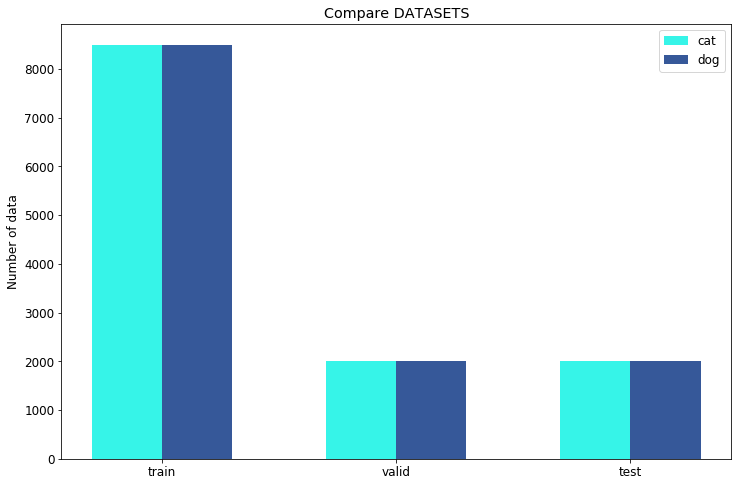

In [7]:
label = ['train', 'valid','test']
cat = [num_cats_tr,num_cats_val,num_cats_test]
dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

plt.rcParams["font.size"] = 12

plt.figure(figsize=(12,8))

x = np.arange(len(label))

plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FF0000')
plt.bar(x+0.15, dog, label='dog', width=0.3, color='#FFFF00')
plt.legend()
plt.xticks(x, label)
plt.ylabel('Number of data')
plt.title('Compare DATASETS')


plt.show()

In [8]:
BATCH_SIZE = 32
IMAGE_WIDTH= 224
IMAGE_HEIGHT= 224

#이미지 제너레이터 생성
imageGenerator = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True) # Generator for our training data
val_imageGenerator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
test_imageGenerator = ImageDataGenerator(rescale=1./255)

trainGen = imageGenerator.flow_from_directory(
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    directory=Train_dir,
    batch_size = BATCH_SIZE,
    shuffle=True,
    class_mode='binary'
)

validationGen = val_imageGenerator.flow_from_directory(
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    directory=Vaild_dir,
    batch_size = BATCH_SIZE,
    class_mode='binary',
)
testGen = test_imageGenerator.flow_from_directory(
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        directory=Test_dir,
        shuffle=False,
        batch_size=50,
        class_mode='binary')

Found 17000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [0]:
def conv2d(x, filters):
    x = Conv2D(filters, kernel_size=(3,3), kernel_initializer='he_normal',padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [0]:
inputs = Input(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
x = conv2d(inputs, 64)
x = conv2d(x, 64)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)
x = conv2d(x, 128)
x = conv2d(x, 128)
x = MaxPooling2D()(x)
x = BatchNormalization()(x)
x = conv2d(x, 256)
x = conv2d(x, 256)
x = conv2d(x, 256)
x = MaxPooling2D()(x)
x = conv2d(x, 512)
x = conv2d(x, 512)
x = conv2d(x, 512)
x = MaxPooling2D()(x)
x = conv2d(x, 512)
x = conv2d(x, 512)
x = conv2d(x, 512)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)

output_image = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

model = Model(inputs=inputs, outputs=output_image)

In [31]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_123 (Bat (None, 224, 224, 64)      256       
_________________________________________________________________
activation_91 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_124 (Bat (None, 224, 224, 64)      256       
_________________________________________________________________
activation_92 (Activation)   (None, 224, 224, 64)      0   

In [0]:
#model = tf.keras.models.load_model('/content/gdrive/My Drive/model/lre5ep300.h5')

In [0]:
model.compile(
    optimizers= 'Adadelta',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [45]:
epochs =100
history = model.fit_generator(
    trainGen,
    steps_per_epoch= 30,
    epochs=epochs,
    validation_data= validationGen,
    validation_steps= 10
)

Epoch 1/100
30/30 [==============================] - 18s 585ms/step - loss: 0.2518 - acc: 0.8969 - val_loss: 0.2502 - val_acc: 0.8969
Epoch 2/100
30/30 [==============================] - 17s 568ms/step - loss: 0.2395 - acc: 0.8938 - val_loss: 0.2533 - val_acc: 0.9000
Epoch 3/100
30/30 [==============================] - 17s 563ms/step - loss: 0.2278 - acc: 0.9031 - val_loss: 0.2725 - val_acc: 0.8906
Epoch 4/100
30/30 [==============================] - 17s 563ms/step - loss: 0.2065 - acc: 0.9135 - val_loss: 0.2907 - val_acc: 0.8750
Epoch 5/100
30/30 [==============================] - 17s 555ms/step - loss: 0.2199 - acc: 0.9081 - val_loss: 0.2503 - val_acc: 0.8844
Epoch 6/100
30/30 [==============================] - 17s 562ms/step - loss: 0.2108 - acc: 0.9125 - val_loss: 0.4723 - val_acc: 0.8188
Epoch 7/100
30/30 [==============================] - 17s 564ms/step - loss: 0.2340 - acc: 0.9104 - val_loss: 0.3298 - val_acc: 0.8813
Epoch 8/100
30/30 [==============================] - 17s 563ms

In [46]:
scores = model.evaluate_generator(testGen, steps=testGen.samples//50,verbose=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

80/80 [==============================] - 791s 10s/step - loss: 0.2140 - acc: 0.9195
acc: 91.95%


In [0]:
model.save('/content/gdrive/My Drive/model/vgg_ada_400.h5')

In [0]:
import cv2
TEST_PATH = '/content/gdrive/My Drive/dataset/test/cat/cat.0.jpg'
img = cv2.imread(TEST_PATH)
img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
x = img.copy()
x.astype(np.float32)
x = x / 255.0

In [0]:
# 모델 output, name 가져오기
def Layers_predict(model, image):
    output_layers = [layer.output for layer in model.layers[1:36] if layer.name[:5]!='batch']
    output_names = [layer.name for layer in model.layers[1:36] if layer.name[:5]!='batch']
    new_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
    new_model_pred = new_model.predict(image)
    return new_model_pred, output_names

In [0]:
predictions = new_model.predict_generator(testGen, steps=testGen.samples//50,verbose=1)

80/80 [==============================] - 906s 11s/step


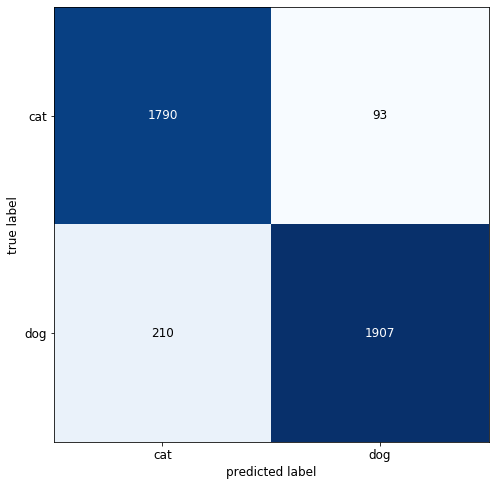

In [0]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

for index,i in enumerate(predictions):
    if i >= 0.5:
        predictions[index] = 1
    else:
         predictions[index]= 0
class_name = ['cat', 'dog']         
cm = confusion_matrix(predictions,testGen.classes)
fig, ax = plot_confusion_matrix(conf_mat=cm,figsize=(8,8))

ax.set_xticklabels([''] + class_name)
ax.set_yticklabels([''] + class_name)
plt.xlabel
plt.show()